In [1]:
import sys
sys.path.append('../..')
from src.pomdp import *

import pandas as pd
# import numpy as np
import cupy as np


## Model definition

In [2]:
# olfactory_data = pd.read_csv('./Data/statistics_nose_3e6_35_153.dat', sep=',', header=None).values
# olfactory_data = np.array(olfactory_data)

In [2]:
olfactory_data = pd.read_csv('./Data/statistics_nose_5e6.dat', sep=' ', skiprows=[0], header=None).values.T
olfactory_data = np.array(olfactory_data[:320,:])

In [3]:
# Model size
# env_shape = (280, 1225)
# env_shape = (70,153)
env_shape = olfactory_data.shape
state_count = env_shape[0] * env_shape[1]

print(f'Environment shape: {env_shape}')
print(f'State count: {state_count}')

Environment shape: (320, 1300)
State count: 416000


In [4]:
# goal state
olfactory_data[17,0]

array(0.)

In [5]:
def id_from_pos(x,y):
    return (x * env_shape[1]) + y

In [6]:
# states
state_grid = []

# Rewards
# rewards = np.zeros((state_count, 4, state_count,2))
# rewards[:,:,id_from_pos(17,0),:] = 1

# observation matrix
flattened_olfactory_data = olfactory_data.flatten()

observations = np.zeros((state_count, 4, 2))
observations[:,:,0] = flattened_olfactory_data.reshape((flattened_olfactory_data.shape[0],1)).repeat(4, axis=1)
observations[:,:,1] = (1 - observations[:,:,0])

# Transitions and state labels
for i in range(env_shape[0]):
    i_states = []
    for j in range(env_shape[1]):
        i_states.append(f's_{i}_{j}')

    state_grid.append(i_states)

In [7]:
import numpy
row_w = env_shape[1]

reachable_states = numpy.zeros((state_count, 4, 1), dtype=int)
for s in range(state_count):
    reachable_states[s,0,0] = s - row_w if s - row_w >= 0 else s # North
    reachable_states[s,1,0] = s + 1 if (s + 1) % row_w > 0 else s # East
    reachable_states[s,2,0] = s + row_w if s + row_w < state_count else s # South
    reachable_states[s,3,0] = s - 1 if (s - 1) % row_w < (row_w - 1) else s # West

reachable_states = np.array(reachable_states)

In [8]:
# Reward function
def reward_func(s,a,sn,o):
    # return np.where(sn == (175*env_shape[1]), 1.0, 0.0)
    return np.where(sn == (17*env_shape[1]), 1.0, 0.0)

In [9]:
model = Model(
    states=state_grid,
    actions=['N','E','S','W'],
    observations=['something', 'nothing'],
    reachable_states=reachable_states,
    rewards=reward_func,
    observation_table=observations,
    end_states=[id_from_pos(17,0)]
)

[09/25/2023, 01:46:49] Instantiation of MDP Model:
[09/25/2023, 01:46:49] - 416000 states
[09/25/2023, 01:46:49] - 4 actions
[09/25/2023, 01:46:49] - At most 1 reachable states per state-action pair
[09/25/2023, 01:46:49] - Starting generation of transitions table
[Warning] No transition matrix or function provided but reachable states are, so probability to reach any reachable states will "1 / reachable state count" so here: 1.000.
[09/25/2023, 01:46:49]     > Done in 0.000s
[09/25/2023, 01:46:49] - Generating start probabilities table
[09/25/2023, 01:46:49] - Starting computation of reachable state probabilities from transition data
[09/25/2023, 01:46:49]     > Done in 0.001s
[09/25/2023, 01:46:49] POMDP particular parameters:
[09/25/2023, 01:46:49] - 2 observations
[09/25/2023, 01:46:49] - Starting of transitional observations for reachable states table
[09/25/2023, 01:46:49]     > Done in 0.051s
[09/25/2023, 01:46:49] - Starting generation of expected rewards table
[09/25/2023, 01:

## Experiments

In [11]:
b = Belief(model)
belief_set = np.array([b])
belief_set = belief_set.repeat(80,axis=0)

In [12]:
value_function = ValueFunction(model, [AlphaVector(model.expected_rewards_table[:,a], a) for a in model.actions] * 20).alpha_vector_array

In [13]:
gamma = 0.99
gamma_a_o_t = gamma * np.einsum('saor,vsar->aovs', model.reachable_transitional_observation_table, value_function[np.arange(value_function.shape[0])[:,None,None,None], model.reachable_states[None,:,:,:]])

In [14]:
best_alpha_ind = np.argmax(np.tensordot(belief_set, gamma_a_o_t, (1,3)), axis=3)

In [16]:
best_alpha_ind.shape

(80, 4, 2)

In [17]:
gamma_a_o_t.shape

(4, 2, 80, 5355)

In [18]:
import numpy.ma as ma

In [ ]:
ma.array()

In [31]:
(*best_alpha_ind.shape, model.state_count)

(80, 4, 2, 416000)

In [33]:
best_alphas_per_o = np.zeros((*best_alpha_ind.shape, model.state_count))
it = np.nditer(best_alpha_ind, flags=['multi_index'], op_flags=['readonly'])
for x in it:
    (b,a,o) = it.multi_index
    best_alphas_per_o[b,a,o,:] = gamma_a_o_t[a,o,x,:]

In [34]:
best_alphas_per_o_2 = gamma_a_o_t[model.actions[None,:,None,None], model.observations[None,None,:,None], best_alpha_ind[:,:,:,None], model.states[None,None,None,:]]

In [38]:
best_alphas_per_o_2 = gamma_a_o_t[:,:,best_alpha_ind[:,:,:,None],:]

In [39]:
np.argwhere(best_alphas_per_o != best_alphas_per_o_2)

ValueError: operands could not be broadcast together with shapes (80,4,2,416000) (4,2,80,4,2,1,416000) 

In [59]:
# Reworked 2
def t3():
    best_alpha_ind = np.argmax(np.tensordot(beliefs, gamma_a_o_t, (1,3)), axis=3)

    best_alphas_per_o = np.zeros((*best_alpha_ind.shape, model.state_count))
    it = np.nditer(best_alpha_ind, flags=['multi_index'], op_flags=['readonly'])
    for x in it:
        (b,a,o) = it.multi_index
        best_alphas_per_o[b,a,o,:] = gamma_a_o_t[a,o,x,:]

    alpha_a = np.sum(best_alphas_per_o, axis=2)
    alpha_a += model.expected_rewards_table.T

    new_value_function = np.zeros(beliefs.shape)
    for i, b in enumerate(beliefs):
        best_ind = np.argmax(np.dot(alpha_a[i,:,:], b))
        new_value_function[i,:] = alpha_a[i, best_ind,:]

In [60]:
%timeit t3()

950 ms ± 69.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [31]:
# Reworked
def t2():
    best_alpha_ind = np.argmax(np.dot(beliefs, gamma_a_o_t.swapaxes(3,2)), axis=3)

    best_alphas_per_o = np.zeros((*best_alpha_ind.shape, model.state_count))
    it = np.nditer(best_alpha_ind, flags=['multi_index'], op_flags=['readonly'])
    for x in it:
        (b,a,o) = it.multi_index
        best_alphas_per_o[b,a,o,:] = gamma_a_o_t[a,o,x,:]

    alpha_a = np.sum(best_alphas_per_o, axis=2)
    alpha_a += model.expected_rewards_table.T

    new_value_function = np.zeros(beliefs.shape)
    for i, b in enumerate(beliefs):
        best_ind = np.argmax(np.dot(alpha_a[i,:,:], b))
        new_value_function[i,:] = alpha_a[i, best_ind,:]

In [32]:
%timeit t2()

34.8 s ± 1.48 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [23]:
def t1():
    for b in beliefs:
        best_alpha = None
        best_alpha_val = -np.inf

        for a in model.actions:
            
            obs_alpha_sum = np.zeros(model.state_count)
            
            for o in model.observations:
                
                # Argmax of alphas
                best_alpha_o = np.zeros(model.state_count)
                best_alpha_o_val = -np.inf
                
                for alpha_o in gamma_a_o_t[a][o]:
                    val = np.dot(alpha_o, b)
                    if val > best_alpha_o_val:
                        best_alpha_o_val = val
                        best_alpha_o = alpha_o
                        
                # Sum of the alpha_obs vectors
                obs_alpha_sum += best_alpha_o

            alpha_a_vect = model.expected_rewards_table[:,a] + obs_alpha_sum

            # Step 3
            val = np.dot(alpha_a_vect, b)
            if val > best_alpha_val:
                best_alpha_val = val
                best_alpha = AlphaVector(alpha_a_vect, a)

In [24]:
%timeit t1()

3min 37s ± 3.97 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


## VI Solve

In [8]:
from src.mdp import VI_Solver

In [9]:
solver = VI_Solver()

In [10]:
solution, history = solver.solve(model)

  0%|          | 0/10000 [00:00<?, ?it/s]

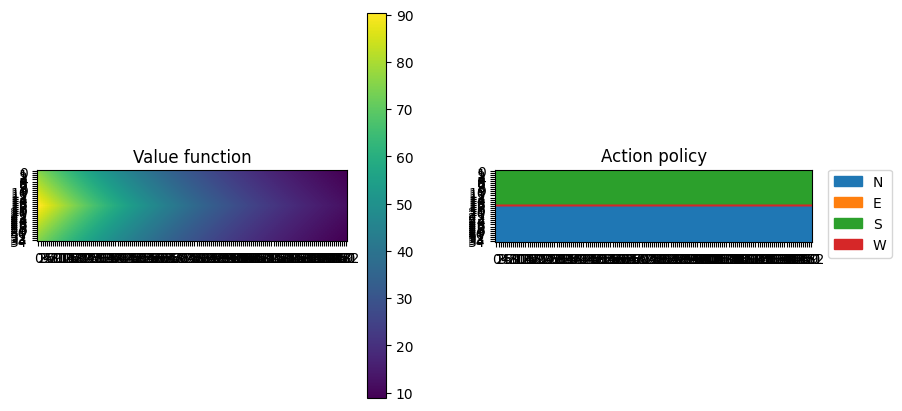

In [11]:
solution.plot()

In [13]:
np.array(solution).shape

(4, 5355)

## Solving timing

regular size

In [8]:
solver = PBVI_Solver(eps=10e-5)
value_function = ValueFunction(model, [AlphaVector(model.expected_rewards_table[:,a], a) for a in model.actions])
belief_set = [Belief(model)]

In [10]:
%timeit solver.backup(model, belief_set, value_function)

670 ms ± 19 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


double size

In [8]:
solver = PBVI_Solver(eps=10e-5)
value_function = ValueFunction(model, [AlphaVector(model.expected_rewards_table[:,a], a) for a in model.actions])
belief_set = [Belief(model)]

In [9]:
%timeit solver.backup(model, belief_set, value_function)

45.9 s ± 618 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


regular size (reachable)

In [8]:
solver = PBVI_Solver(eps=10e-5)
value_function = ValueFunction(model, [AlphaVector(model.expected_rewards_table[:,a], a) for a in model.actions])
belief_set = [Belief(model)]

In [9]:
%timeit solver.backup(model, belief_set, value_function)

2.57 ms ± 80.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Double size (reachable)

In [8]:
solver = PBVI_Solver(eps=10e-5)

In [10]:
value_function = ValueFunction(model, [AlphaVector(model.expected_rewards_table[:,a], a) for a in model.actions])
belief_set = [Belief(model)]

In [11]:
%timeit solver.backup(model, belief_set, value_function)

10.9 ms ± 418 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Solving profiling

In [10]:
solver = PBVI_Solver(eps=10e-8)

In [11]:
# solution, history = solver.solve(model, 8, 8)

In [12]:
model.expected_rewards_table.shape

(416000, 4)

In [13]:
from cProfile import Profile
from pstats import SortKey, Stats


with Profile() as profile:
    solver.solve(model, 4, 8)
    print(f"")
    (
        Stats(profile)
        .strip_dirs()
        .sort_stats(SortKey.CALLS)
        .print_stats()
    )

Expansions:   0%|          | 0/4 [00:00<?, ?it/s]

Backups 0:   0%|          | 0/8 [00:00<?, ?it/s]

Backups 1:   0%|          | 0/8 [00:00<?, ?it/s]

Backups 2:   0%|          | 0/8 [00:00<?, ?it/s]

Backups 3:   0%|          | 0/8 [00:00<?, ?it/s]


         203339 function calls (193847 primitive calls) in 8.496 seconds

   Ordered by: call count

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
    17804    0.005    0.000    0.009    0.000 {built-in method builtins.isinstance}
10089/10007    0.002    0.000    0.002    0.000 {built-in method builtins.len}
8772/5677    0.003    0.000    0.033    0.000 traitlets.py:692(__get__)
7190/5170    0.004    0.000    0.031    0.000 traitlets.py:654(get)
     6924    0.001    0.000    0.001    0.000 {method 'append' of 'list' objects}
6643/4388    0.004    0.000    0.029    0.000 {built-in method builtins.getattr}
     5767    0.001    0.000    0.001    0.000 {method 'get' of 'dict' objects}
     3778    0.006    0.000    0.012    0.000 numeric.py:1855(isscalar)
     3384    0.002    0.000    0.002    0.000 {built-in method builtins.hasattr}
     2881    0.001    0.000    0.001    0.000 {method 'endswith' of 'str' objects}
     2726    0.000    0.000    0.000    0.000

: 

In [25]:
import os
print(os.environ["TEMP"])

C:\Users\arnau\AppData\Local\Temp


In [13]:
from cProfile import Profile
from pstats import SortKey, Stats


with Profile() as profile:
    solver.solve(model, 4, 8)
    print(f"")
    (
        Stats(profile)
        .strip_dirs()
        .sort_stats(SortKey.CALLS)
        .print_stats()
    )

Expansions:   0%|          | 0/4 [00:00<?, ?it/s]

Backups 0:   0%|          | 0/8 [00:00<?, ?it/s]

Backups 1:   0%|          | 0/8 [00:00<?, ?it/s]

Backups 2:   0%|          | 0/8 [00:00<?, ?it/s]

Backups 3:   0%|          | 0/8 [00:00<?, ?it/s]


         103472 function calls (95474 primitive calls) in 18.502 seconds

   Ordered by: call count

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
10170/7075    0.004    0.000    0.035    0.000 traitlets.py:692(__get__)
     8798    0.002    0.000    0.002    0.000 {built-in method builtins.isinstance}
8504/6484    0.004    0.000    0.031    0.000 traitlets.py:654(get)
6515/4260    0.003    0.000    0.029    0.000 {built-in method builtins.getattr}
     4066    0.001    0.000    0.001    0.000 {method 'get' of 'dict' objects}
     3248    0.002    0.000    0.002    0.000 {built-in method builtins.hasattr}
2710/2707    0.001    0.000    0.001    0.000 {built-in method builtins.len}
     2134    0.000    0.000    0.000    0.000 {method 'items' of 'dict' objects}
     1780    0.000    0.000    0.000    0.000 {built-in method builtins.callable}
     1725    0.000    0.000    0.000    0.000 traitlets.py:263(__init__)
     1725    0.000    0.000    0.000    0.000 t